In [33]:
# System identification python code

####################### PACKAGES #######################
import numpy as np
import numpy.linalg
import numpy.matlib

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import OrthogonalMatchingPursuit

from scipy.integrate import odeint

import pandas as pd

import matplotlib.pyplot as plt

## CVXPY package
import cvxpy as cp

In [34]:
####################### FUNCTIONS #######################
# Define local functions
def loss_fn(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2

def regularizer(beta):
    return cp.norm1(beta)

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

# Simulate dynamical system

def duffing(x, t, gamma=0.1, kappa=1, epsilon=5):
    # Compute dynamics
    dsdt = [x[1], -gamma * x[1] - kappa * x[0] - epsilon * x[0] ** 3]
    return dsdt

gamma=0.1
kappa=1
epsilon=5

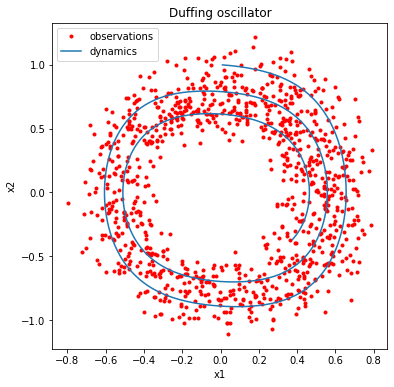

In [35]:
####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 10  # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n_states = 2 #Number of state variables
t_span = np.linspace(t0, tf, n_times)
x0 = [0, 1]
X = odeint(duffing, x0, t_span)
x1 = X[:,0]
x2 = X[:,1]

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0.1
E = sigma * np.random.randn(n_times,n_states)#Additive zero-mean white noise (Assumed Gaussian)

Y = X[1:,:] + E[1:,:] #(remove initial condition)
X = X[1:,:]#(remove initial condition)
t = t_span[1:]
m_samples = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]

#Plot dynamical system and observations
plt.figure(figsize = (6,6))
plt.plot(y1,y2,'r.')
plt.plot(x1[1:],x2[1:])
plt.title('Duffing oscillator')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['observations','dynamics'])
plt.show()

In [36]:
# NOISELESS CASE

#Generate multi-variate Vandermonde matrix of degree poly_d in n variables
poly_d = 3
poly_t = PolynomialFeatures(poly_d)
Phi_t = poly_t.fit_transform(X)
p_basis = Phi_t.shape[1]#Number of basis functions

#Generate LHS and integral matrix of the integral formulation using simple quadrature
DX = X - np.matlib.repmat(x0, m_samples, 1)# LHS
delta_t = t_span[1:] - t_span[0:-1]# Array with time increments for all samples in case the time grid is non-uniform
Delta_t = np.transpose(np.matlib.repmat(delta_t,p_basis,1))# Reshape for convenience

t_int_t = np.zeros(m_samples)
I_t = np.zeros((m_samples,p_basis))

for i in range(m_samples):
    I_t[i,:] = np.sum(Delta_t[0:i,:] * Phi_t[0:i,:],axis = 0)
    t_int_t[i] = np.sum(delta_t[0:i])
    

In [37]:
# NOISY CASE

#Generate multi-variate Vandermonde matrix of degree poly_d in n variables
poly_d = 3
poly = PolynomialFeatures(poly_d)
Phi = poly.fit_transform(Y)
p = Phi.shape[1]#Number of basis functions
basis_names = poly.get_feature_names()

#Generate LHS and integral matrix of the integral formulation using simple quadrature
DY = Y - np.matlib.repmat(x0, m_samples, 1)# LHS
delta_t = t_span[1:] - t_span[0:-1]# Array with time increments for all samples in case the time grid is non-uniform
Delta_t = np.transpose(np.matlib.repmat(delta_t,p_basis,1))# Reshape for convenience

t_int = np.zeros(m_samples)
I = np.zeros((m_samples,p_basis))

for i in range(m_samples):
    I[i,:] = np.sum(Delta_t[0:i,:] * Phi[0:i,:],axis = 0)
    t_int[i] = np.sum(delta_t[0:i])

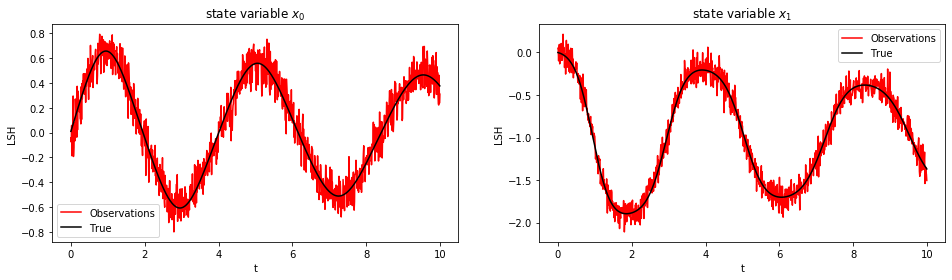

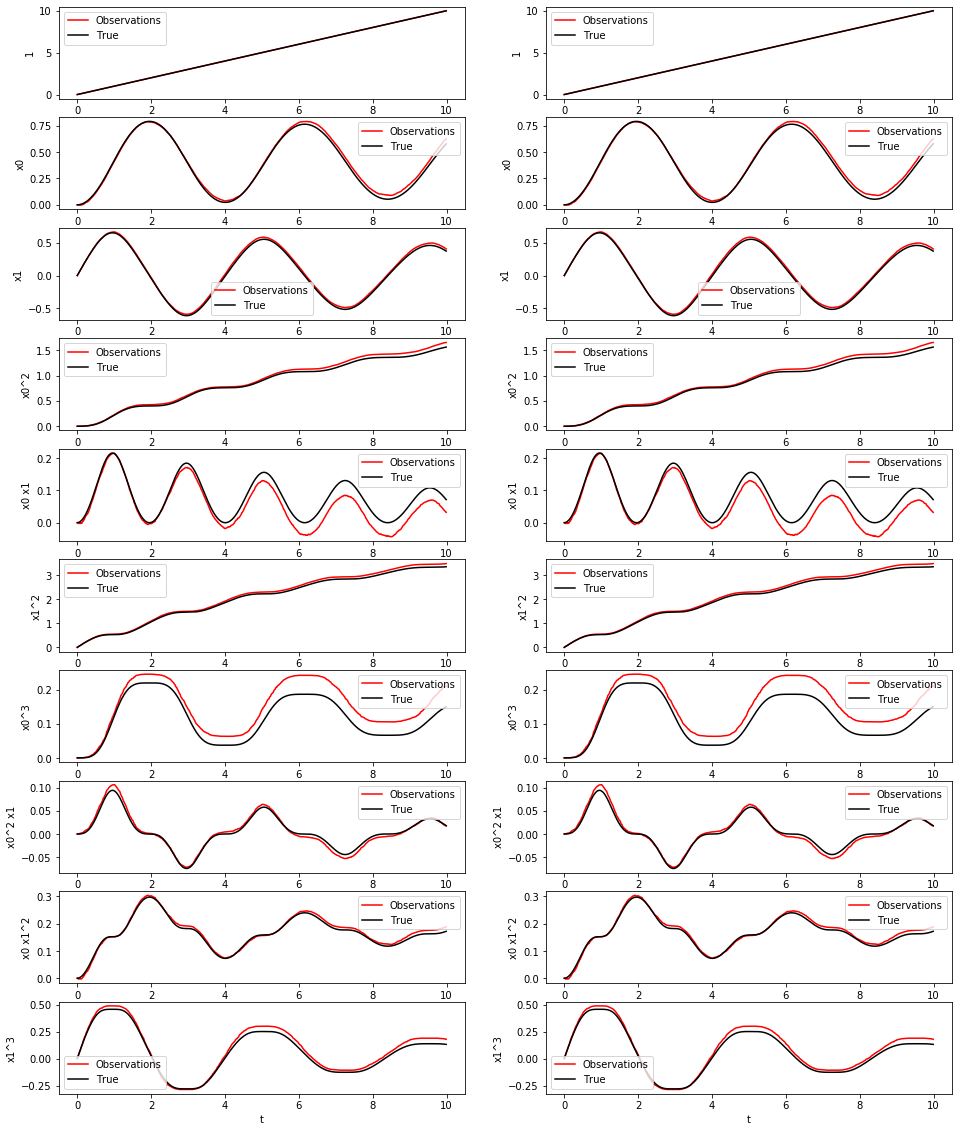

In [38]:
#Compare true and noisy LHS
fig, axs = plt.subplots(1, n_states, figsize=(16,4))

for state in range(n_states):

    axs[state].plot(t_int, DY[:,state],'r')
    axs[state].plot(t_int_t, DX[:,state],'k')
    axs[state].set_title(r'state variable $x_{0}$'.format(state))
    axs[state].set_xlabel('t')
    axs[state].set_ylabel('LSH')
    axs[state].legend(['Observations', 'True'])
    
fig2,axs2 = plt.subplots(p_basis, n_states,figsize=(16,20))

for i in range(p_basis):
    for j in range(n_states):
        axs2[i,j].plot(t_int,I[:,i],'r')
        axs2[i,j].plot(t_int_t,I_t[:,i],'k')
        axs2[i,j].set_xlabel('t')
        axs2[i,j].set_ylabel(basis_names[i])
        axs2[i,j].legend(['Observations', 'True'])

In [39]:
# SOLVE SYSTEM
C_t = np.zeros((p_basis, n_states))
C = np.zeros((p_basis, n_states))
C_omp_t = np.zeros((p_basis, n_states))
C_omp = np.zeros((p_basis, n_states))
lambda_reg = 0
sparsity = [1, 3]

for state in range(n_states):
    
    #L1 regularization
    beta_t = cp.Variable(p_basis)
    beta = cp.Variable(p_basis)
    lambd = cp.Parameter(nonneg=True)
    problem_t = cp.Problem(cp.Minimize(objective_fn(I_t, DX[:,state], beta_t, lambd)))#noiseless
    problem = cp.Problem(cp.Minimize(objective_fn(I, DY[:,state], beta, lambd))) #noisy
    lambd.value = lambda_reg
    problem_t.solve()
    problem.solve()
    C_t[:, state] = beta_t.value
    C[:, state] = beta.value
    
    #Orthogonal matching pursuit
    omp_t = OrthogonalMatchingPursuit(n_nonzero_coefs=sparsity[state])
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=sparsity[state])
    omp_t.fit(I_t, DX[:,state])
    omp.fit(I, DY[:,state])
    C_omp_t[:,state] = omp_t.coef_
    C_omp[:,state] = omp.coef_

In [41]:
C_t[np.abs(C_t) < 0.001] = 0
C[np.abs(C) < 0.001] = 0
print('Exact data - l1-regularization')
print(C_t)
print('\n')
print('Observations - l1-regularization')
print(C)
print('\n')
print('Exact data - OMP')
print(C_omp_t)
print('\n')
print('Observations - OMP')
print(C_omp)

Exact data - l1-regularization
[[-1.96514043e-03  0.00000000e+00]
 [-1.53313324e-02 -9.98476584e-01]
 [ 9.96631365e-01 -1.04642267e-01]
 [ 0.00000000e+00  0.00000000e+00]
 [ 1.00125685e-02 -1.04710399e-03]
 [ 6.58249889e-03  0.00000000e+00]
 [-1.11381670e-02 -4.99798570e+00]
 [-1.68234304e-02 -7.32127328e-02]
 [ 3.97749319e-02 -4.62925680e-03]
 [ 1.25628341e-02 -1.32700926e-03]]


Observations - l1-regularization
[[ 0.00807355 -0.02827871]
 [ 0.06715679 -0.6428704 ]
 [ 1.00668092 -0.14507212]
 [ 0.02771832  0.25351245]
 [ 0.05444797 -0.0379566 ]
 [-0.0383518   0.06043436]
 [-0.2276523  -5.74515733]
 [-0.06515031  0.01106273]
 [ 0.05612127 -0.29768844]
 [-0.02333255  0.02271039]]


Exact data - OMP
[[ 0.          0.        ]
 [ 0.         -2.22159443]
 [ 1.00012226 -0.06062039]
 [ 0.         -0.04852346]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


Observations - OMP
[